<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/alignn_ff_related_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install alignn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.8/973.8 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 30.6 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling

In [2]:
from jarvis.db.figshare import data
ff_db=data('alignn_ff_db')

Obtaining ALIGNN-FF training DB 300k ...
Reference:https://arxiv.org/abs/2209.05554


100%|██████████| 72.5M/72.5M [00:03<00:00, 23.9MiB/s]


Loading the zipfile...
Loading completed.


In [3]:

from alignn.ff.ff import default_path,ForceField
from alignn.graphs import Graph
import torch
import os
from jarvis.db.jsonutils import loadjson
from alignn.models.alignn_atomwise import ALIGNNAtomWise,ALIGNNAtomWiseConfig
torch.cuda.is_available = lambda : False
from jarvis.core.atoms import Atoms
from tqdm import tqdm
import numpy as np
from alignn.ff.ff import default_path,ForceField
from jarvis.core.atoms import Atoms
from alignn.ff.ff import AlignnAtomwiseCalculator,default_path
from ase.stress import full_3x3_to_voigt_6_stress
import torch


model_path = default_path()
calc = AlignnAtomwiseCalculator(path=model_path)


def get_alignn_forces(atoms=[]):
    ase_atoms=atoms.ase_converter()
    ase_atoms.calc = calc
    e = ase_atoms.get_potential_energy()
    f = ase_atoms.get_forces()
    s = ase_atoms.get_stress()
    return e,f,s

torch.cuda.is_available = lambda : False
mg=[]

al_e=[]
al_f=[]
al_s=[]

t_e=[]
t_f=[]
t_s=[]
for ii,i in tqdm(enumerate(ff_db[-25:])):
    #if ii<10:
        atoms = Atoms.from_dict(i['atoms'])
        #mg_f = get_m3gnet_forces(atoms)
        #mg.append(np.array(mg_f).flatten())
        e,f,s = get_alignn_forces(atoms)
        al_e.append(e)
        t_e.append(i['total_energy']*atoms.num_atoms)
        
        al_f.append(np.array(f).flatten())
        t_f.append(np.array(i['forces']).flatten())
        ts=full_3x3_to_voigt_6_stress(i['stresses'])
        al_s.append(np.array(s).flatten())
        t_s.append(np.array(ts).flatten())
        


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
model_path /usr/local/lib/python3.10/dist-packages/alignn/ff


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/alignn/graphs.py:237: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  g.ndata["lattice_mat"] = torch.tensor(
/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
25it [00:34,  1.37s/it]


Text(0, 0.5, 'FF Forces(eV/A)')

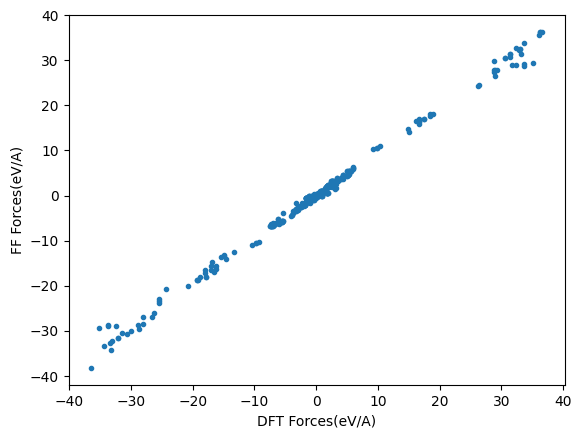

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.concatenate(t_f).flatten(),np.concatenate(al_f).flatten(),'.')
plt.xlabel('DFT Forces(eV/A)')
plt.ylabel('FF Forces(eV/A)')

Text(0, 0.5, 'FF Energy(eV)')

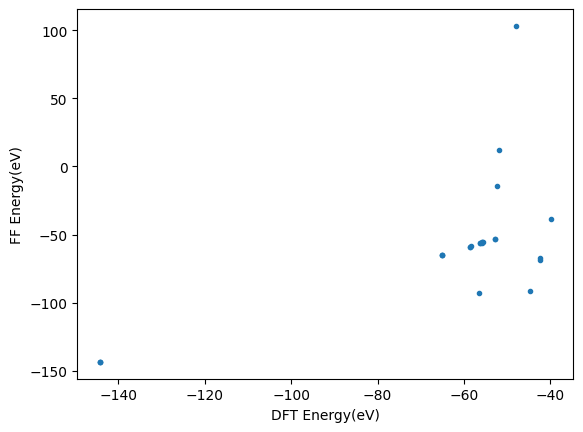

In [8]:
plt.plot(t_e,al_e,'.')
plt.xlabel('DFT Energy(eV)')
plt.ylabel('FF Energy(eV)')

Text(0, 0.5, 'FF Stress(eV/A2)')

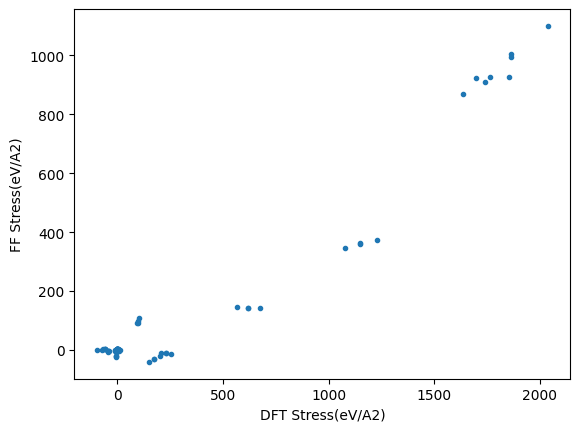

In [9]:
plt.plot(np.concatenate(t_s),-1600*np.concatenate(al_s),'.')
plt.xlabel('DFT Stress(eV/A2)')
plt.ylabel('FF Stress(eV/A2)')